In [1]:
#| default_exp utils

# Aggregation/Visualization Utils

> The `HierarchicalForecast` package contains utility functions to wrangle and visualize 
hierarchical series datasets. The `aggregate` function of the module allows you to create
a hierarchy from categorical variables representing the structure levels, returning also
the aggregation contraints matrix $\mathbf{S}$.

In [2]:
#| export
import sys
import timeit
from itertools import chain
from typing import Callable, Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
# from matplotlib import rcParams
from mycolorpy import colorlist as mcp

plt.rcParams['font.family'] = 'serif'

In [3]:
#| hide
from fastcore.test import test_eq, test_close
from nbdev.showdoc import add_docs, show_doc

In [4]:
#| exporti
class CodeTimer:
    def __init__(self, name=None, verbose=True):
        self.name = " '"  + name + "'" if name else ''
        self.verbose = verbose

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start)
        if self.verbose:
            print('Code block' + self.name + \
                  ' took:\t{0:.5f}'.format(self.took) + ' seconds')

In [5]:
#| exporti
def numpy_balance(*arrs):
    """
    Fast NumPy implementation of balance function.
    The function creates all the interactions between
    the NumPy arrays provided.

    **Parameters:**<br>
    `arrs`: NumPy arrays.<br>

    **Returns:**<br>
    `out`: NumPy array.<br>
    """
    N = len(arrs)
    out =  np.transpose(np.meshgrid(*arrs, indexing='ij'),
                        np.roll(np.arange(N + 1), -1)).reshape(-1, N)
    return out

In [6]:
#| exporti
def _to_summing_matrix(S_df: pd.DataFrame):
    """Transforms the DataFrame `df` of hierarchies to a summing matrix S."""
    categories = [S_df[col].unique() for col in S_df.columns]
    cat_sizes = [len(cats) for cats in categories]
    idx_bottom = np.argmax(cat_sizes)
    cats_bottom = categories[idx_bottom]
    encoder = OneHotEncoder(categories=categories, sparse=False, dtype=np.float32)
    S = encoder.fit_transform(S_df).T
    S = pd.DataFrame(S, index=chain(*categories), columns=cats_bottom)
    tags = dict(zip(S_df.columns, categories))
    return S, tags

In [7]:
#| exporti
def _to_summing_dataframe(Y_bottom_df: pd.DataFrame,
                          spec: List[List[str]]):
    #------------------------------- Wrangling -----------------------------#
    # Keep unique levels, preserving first aparison order
    all_levels = list(chain.from_iterable(spec))
    all_levels = [*dict.fromkeys(all_levels)]

    # Create hierarchical labels
    S_df = Y_bottom_df[all_levels].copy()
    S_df = S_df.drop_duplicates()

    max_len_idx = np.argmax([len(hier) for hier in spec])
    bottom_comb = spec[max_len_idx]
    hiers_cols = []
    for hier in spec:
        if hier == bottom_comb:
            hier_col = 'unique_id'
            bottom_col = '/'.join(hier)
            Y_bottom_df['unique_id'] = Y_bottom_df[hier].agg('/'.join, axis=1)
        else:
            hier_col = '/'.join(hier) 
        S_df[hier_col] = S_df[hier].agg('/'.join, axis=1)
        hiers_cols.append(hier_col)
    S_df = S_df.sort_values(by=bottom_comb)
    S_df = S_df[hiers_cols]

    #------------------------------- Encoding ------------------------------#
    # One hot encode only aggregate levels
    # TODO: option to only operate with sparse matrices
    bottom_ids = list(S_df.unique_id)
    del S_df['unique_id']
    categories = [S_df[col].unique() for col in S_df.columns]
    tags = dict(zip(S_df.columns, categories))
    tags[bottom_col] = bottom_ids

    encoder = OneHotEncoder(categories=categories,
                            sparse=False, dtype=np.float32)
    S = encoder.fit_transform(S_df).T
    S = np.concatenate([S, np.eye(len(bottom_ids))], axis=0)
    S_df = pd.DataFrame(S, columns=bottom_ids,
                        index=list(chain(*categories))+bottom_ids)

    # Match index ordering of S_df and Y_bottom_df
    Y_bottom_df.unique_id = Y_bottom_df.unique_id.astype('category')
    Y_bottom_df.unique_id = Y_bottom_df.unique_id.cat.set_categories(S_df.columns)
    return Y_bottom_df, S_df, tags

# <span style="color:DarkBlue"> Aggregate Function </span>

In [8]:
#| exporti
def aggregate_before(df: pd.DataFrame,
              spec: List[List[str]],
              agg_fn: Callable = np.sum):
    """Utils Aggregation Function.

    Aggregates bottom level series contained in the pd.DataFrame `df` according 
    to levels defined in the `spec` list applying the `agg_fn` (sum, mean).

    **Parameters:**<br>
    `df`: pd.DataFrame with columns `['ds', 'y']` and columns to aggregate.<br>
    `spec`: List of levels. Each element of the list contains a list of columns of `df` to aggregate.<br>
    `agg_fn`: Function used to aggregate `'y'`.<br>

    **Returns:**<br>
    `Y_df, S, tags`: tuple with hierarchically structured series `Y_df` ($\mathbf{y}_{[a,b]}$),
    summing matrix `S`, and hierarchical aggregation indexes `tags`.
    """
    max_len_idx = np.argmax([len(hier) for hier in spec])
    bottom_comb = spec[max_len_idx]
    df_hiers = []
    for hier in spec:
        df_hier = df.groupby(hier + ['ds'])['y'].apply(agg_fn).reset_index()
        df_hier['unique_id'] = df_hier[hier].agg('/'.join, axis=1)
        if hier == bottom_comb:
            bottom_hier = df_hier['unique_id'].unique()
        df_hiers.append(df_hier)
    df_hiers = pd.concat(df_hiers)
    S_df = df_hiers[['unique_id'] + bottom_comb].drop_duplicates().reset_index(drop=True)
    S_df = S_df.set_index('unique_id')
    S_df = S_df.fillna('agg')
    hiers_cols = []
    for hier in spec:
        hier_col = '/'.join(hier) 
        S_df[hier_col] = S_df[hier].agg('/'.join, axis=1)
        hiers_cols.append(hier_col)
    Y_df = df_hiers[['unique_id', 'ds', 'y']].set_index('unique_id')
    
    # Aggregations constraints S definition
    S, tags = _to_summing_matrix(S_df.loc[bottom_hier, hiers_cols])
    return Y_df, S, tags

In [9]:
#| export
def aggregate(df: pd.DataFrame,
              spec: List[List[str]],
              is_balanced: bool=False):
    """ Utils Aggregation Function.

    Aggregates bottom level series contained in the pd.DataFrame `df` according 
    to levels defined in the `spec` list applying the `agg_fn` (sum, mean).

    **Parameters:**<br>
    `df`: pd.DataFrame with columns `['ds', 'y']` and columns to aggregate.<br>
    `spec`: List of levels. Each element of the list contains a list of columns of `df` to aggregate.<br>
    `is_balanced`: bool=False, wether `Y_bottom_df` is balanced, if not we balance.<br>

    **Returns:**<br>
    `Y_df, S_df, tags`: tuple with hierarchically structured series `Y_df` ($\mathbf{y}_{[a,b]}$),
    summing dataframe `S_df`, and hierarchical aggregation indexes `tags`.
    """
    #-------------------------------- Wrangling --------------------------------#
    # Y_bottom_df's unique_id enrichment, and constraints S_df
    Y_bottom_df, S_df, tags = _to_summing_dataframe(Y_bottom_df=df,
                                                    spec=spec)

    # Create balanced/sorted dataset for numpy aggregation (nan=0)
    # TODO: investigate potential memory speed tradeoff
    if not is_balanced:
        dates         = Y_bottom_df['ds'].unique()
        balanced_prod = numpy_balance(S_df.columns, dates)
        balanced_df   = pd.DataFrame(balanced_prod, columns=['unique_id', 'ds'])
        balanced_df['ds'] = balanced_df['ds'].astype(Y_bottom_df['ds'].dtype)

        Y_bottom_df.set_index(['unique_id', 'ds'], inplace=True)
        balanced_df.set_index(['unique_id', 'ds'], inplace=True)
        balanced_df   = balanced_df.merge(Y_bottom_df[['y']],
                                          how='left', left_on=['unique_id', 'ds'],
                                          right_index=True).reset_index()
        balanced_df['y'].fillna(0, inplace=True)
        Y_bottom_df.reset_index(inplace=True)
    else:
        balanced_df = Y_bottom_df.copy()

    #------------------------------- Aggregation -------------------------------#
    n_agg = S_df.shape[0] - S_df.shape[1]
    Agg = S_df.values[:n_agg, :]
    y_bottom = balanced_df.y.values.reshape(len(S_df.columns), len(dates))
    y_agg = Agg @ y_bottom

    # Create long format hierarchical dataframe
    y_agg = y_agg.flatten()
    y_bottom = y_bottom.flatten()
    Y_df = pd.DataFrame(dict(
                unique_id = np.repeat(S_df.index, len(dates)),
                ds = np.tile(dates, len(S_df.index)),
                y = np.concatenate([y_agg, y_bottom], axis=0)))
    Y_df = Y_df.set_index('unique_id')
    return Y_df, S_df, tags

In [10]:
show_doc(aggregate, title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L161){target="_blank" style="float:right; font-size:smaller"}

### aggregate

>      aggregate (df:pandas.core.frame.DataFrame, spec:List[List[str]],
>                 is_balanced:bool=False)

Utils Aggregation Function.

Aggregates bottom level series contained in the pd.DataFrame `df` according 
to levels defined in the `spec` list applying the `agg_fn` (sum, mean).

**Parameters:**<br>
`df`: pd.DataFrame with columns `['ds', 'y']` and columns to aggregate.<br>
`spec`: List of levels. Each element of the list contains a list of columns of `df` to aggregate.<br>
`is_balanced`: bool=False, wether `Y_bottom_df` is balanced, if not we balance.<br>

**Returns:**<br>
`Y_df, S_df, tags`: tuple with hierarchically structured series `Y_df` ($\mathbf{y}_{[a,b]}$),
summing dataframe `S_df`, and hierarchical aggregation indexes `tags`.

In [28]:
#| hide
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
df = df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
df.insert(0, 'Country', 'Australia')

# grouped structure
hiers_grouped = [['Country'],
                 ['Country', 'State'], 
                 ['Country', 'Purpose'], 
                 ['Country', 'State', 'Region'], 
                 ['Country', 'State', 'Purpose'], 
                 ['Country', 'State', 'Region', 'Purpose']]

# strictly hierarchical structure
hiers_strictly = [['Country'],
                  ['Country', 'State'], 
                  ['Country', 'State', 'Region']]

# test grouped
hier_df, S_df, tags = aggregate(df=df, spec=hiers_grouped)
test_eq(len(hier_df), 34_000)
test_eq(hier_df.index.nunique(), 425)
test_eq(S_df.shape, (425, 304))
test_eq(hier_df.index.unique(), S_df.index)
test_eq(len(tags), len(hiers_grouped))

# test strict
hier_df, S_df, tags = aggregate_before(df=df, spec=hiers_strictly)
test_eq(len(hier_df), 6800)
test_eq(hier_df.index.nunique(), 85)
test_eq(S_df.shape, (85, 76))
test_eq(hier_df.index.unique(), S_df.index)
test_eq(len(tags), len(hiers_strictly))

# test strict
hier_df, S_df, tags = aggregate(df=df, spec=hiers_strictly)
test_eq(len(hier_df), 6800)
test_eq(hier_df.index.nunique(), 85)
test_eq(S_df.shape, (85, 76))
test_eq(hier_df.index.unique(), S_df.index)
test_eq(len(tags), len(hiers_strictly))

In [12]:
#| hide
# Test equality of aggregation and aggregation_before
with CodeTimer('aggregation before'):
    before_Y_df, before_S_df, before_tags = aggregate_before(df=df, spec=hiers_grouped)

with CodeTimer('aggregation now'):
    Y_df, S_df, tags = aggregate(df=df, spec=hiers_grouped)

test_close(Y_df.y.values, before_Y_df.y.values)
test_eq(S_df.values, before_S_df.values)

test_eq(S_df.columns, before_S_df.columns)
test_eq(S_df.index, before_S_df.index)

test_eq(Y_df.columns, before_Y_df.columns)
test_eq(Y_df.index, before_Y_df.index)

Code block 'aggregation before' took:	5.51563 seconds
Code block 'aggregation now' took:	0.41348 seconds


# <span style="color:DarkBlue"> Hierarchical Visualization </span>

In [13]:
#| export
class HierarchicalPlot:
    """ Hierarchical Plot

    This class contains a collection of matplotlib visualization methods, suited for small
    to medium sized hierarchical series.

    **Parameters:**<br>
    `S`: pd.DataFrame with summing matrix of size `(base, bottom)`, see [aggregate function](https://nixtla.github.io/hierarchicalforecast/utils.html#aggregate).<br>
    `tags`: np.ndarray, with hierarchical aggregation indexes, where 
        each key is a level and its value contains tags associated to that level.<br><br>
    """
    def __init__(self,
                 S: pd.DataFrame,
                 tags: Dict[str, np.ndarray]):
        self.S_df = S
        self.tags = tags

    def plot_summing_matrix(self):
        """ Summation Constraints plot
        
        This method simply plots the hierarchical aggregation
        constraints matrix $\mathbf{S}$.
        """
        plt.figure(num=1, figsize=(4, 6), dpi=80, facecolor='w')
        plt.spy(self.S_df)
        plt.show()
        plt.close()

    def plot_series(self,
                    series: str,
                    Y_df: Optional[pd.DataFrame] = None,
                    models: Optional[List[str]] = None,
                    level: Optional[List[int]] = None):
        """ Single Series plot

        **Parameters:**<br>
        `series`: str, string identifying the `'unique_id'` any-level series to plot.<br>
        `Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
                It contains columns `['unique_id', 'ds', 'y']`, it may have `'models'`.<br>
        `models`: List[str], string identifying filtering model columns.
        `level`: float list 0-100, confidence levels for prediction intervals available in `Y_df`.<br>

        **Returns:**<br>
        Single series plot with filtered models and prediction interval level.<br><br>
        """
        if series not in self.S_df.index:
            raise Exception(f'time series {series} not found')
        fig, ax = plt.subplots(1, 1, figsize = (20, 7))
        df_plot = Y_df.loc[series].set_index('ds')
        cols = models if models is not None else df_plot.columns
        cols_wo_levels = [col for col in cols if ('lo' not in col and 'hi' not in col)]
        cmap = mcp.gen_color('tab10', 10)[:len(cols_wo_levels)]
        cmap_dict = dict(zip(cols_wo_levels, cmap))
        df_plot[cols_wo_levels].plot(ax=ax, linewidth=2, color=cmap)
        if level is not None:
            for lv in level:
                for col in cols_wo_levels:
                    if col == 'y':
                        # we dont need intervals
                        # for the actual value
                        continue
                    if f'{col}-lo-{lv}' not in df_plot.columns:
                        # if model
                        # doesnt have levels
                        continue
                    ax.fill_between(
                        df_plot.index, 
                        df_plot[f'{col}-lo-{lv}'], 
                        df_plot[f'{col}-hi-{lv}'],
                        alpha=-lv/50 + 2,
                        color=cmap_dict[col],
                        label=f'{col}_level_{lv}'
                    )
        ax.set_title(f'{series} Forecast', fontsize=22)
        ax.set_xlabel('Timestamp [t]', fontsize=20)
        ax.legend(prop={'size': 15})
        ax.grid()
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(20)
                    
    def plot_hierarchically_linked_series(self,
                                          bottom_series: str,
                                          Y_df: Optional[pd.DataFrame] = None,
                                          models: Optional[List[str]] = None,
                                          level: Optional[List[int]] = None):
        """ Hierarchically Linked Series plot

        **Parameters:**<br>
        `bottom_series`: str, string identifying the `'unique_id'` bottom-level series to plot.<br>
        `Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
                It contains columns ['unique_id', 'ds', 'y'] and models. <br>
        `models`: List[str], string identifying filtering model columns.
        `level`: float list 0-100, confidence levels for prediction intervals available in `Y_df`.<br>

        **Returns:**<br>
        Collection of hierarchilly linked series plots associated with the `bottom_series`
        and filtered models and prediction interval level.<br><br>
        """
        if bottom_series not in self.S_df.columns:
            raise Exception(f'bottom time series {bottom_series} not found')
        linked_series = self.S_df[bottom_series].loc[lambda x: x == 1.].index
        fig, axs = plt.subplots(len(linked_series), 1, figsize=(20, 2 * len(linked_series)))
        cols = models if models is not None else Y_df.drop(['ds'], axis=1)
        cols_wo_levels = [col for col in cols if ('lo' not in col and 'hi' not in col)]
        cmap = mcp.gen_color('tab10', 10)[:len(cols_wo_levels)]
        cmap_dict = dict(zip(cols_wo_levels, cmap))
        for idx, series in enumerate(linked_series):
            df_plot = Y_df.loc[[series]].set_index('ds')
            df_plot[cols_wo_levels].plot(ax=axs[idx], linewidth=2, color=cmap)
            if level is not None:
                for lv in level:
                    for col in cols_wo_levels:
                        if col == 'y':
                            # we dont need intervals
                            # for the actual value
                            continue
                        if f'{col}-lo-{lv}' not in df_plot.columns:
                            # if model
                            # doesnt have levels
                            continue
                        axs[idx].fill_between(
                            df_plot.index, 
                            df_plot[f'{col}-lo-{lv}'], 
                            df_plot[f'{col}-hi-{lv}'],
                            alpha=-lv/50 + 2,
                            color=cmap_dict[col],
                            label=f'{col}_level_{lv}'
                        )
            axs[idx].set_title(f'{series}', fontsize=10)
            axs[idx].grid()
            axs[idx].get_xaxis().label.set_visible(False)
            axs[idx].legend().set_visible(False)
            for label in (axs[idx].get_xticklabels() + axs[idx].get_yticklabels()):
                label.set_fontsize(10)
        plt.subplots_adjust(hspace=0.4)
        handles, labels = axs[0].get_legend_handles_labels()
        kwargs = dict(loc='lower center', 
                      prop={'size': 10}, 
                      bbox_to_anchor=(0, 0.05, 1, 1))
        if sys.version_info.minor > 7:
            kwargs['ncols'] = np.max([2, np.ceil(len(labels) / 2)])
        fig.legend(handles, labels, **kwargs)

    def plot_hierarchical_predictions_gap(self,
                                          Y_df: pd.DataFrame,
                                          models: Optional[List[str]] = None,
                                          xlabel: Optional[str]=None,
                                          ylabel: Optional[str]=None,
                                          ):
        """ Hierarchically Predictions Gap plot

        **Parameters:**<br>
        `Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
                It contains columns ['unique_id', 'ds', 'y'] and models. <br>
        `models`: List[str], string identifying filtering model columns.
        `xlabel`: str, string for the plot's x axis label.
        `ylable`: str, string for the plot's y axis label.

        **Returns:**<br>
        Plots of aggregated predictions at different levels of the hierarchical structure.
        The aggregation is performed according to the tag levels see 
        [aggregate function](https://nixtla.github.io/hierarchicalforecast/utils.html).<br><br>
        """
        # Parse predictions dataframe
        horizon_dates = Y_df['ds'].unique()
        cols = models if models is not None else Y_df.drop(['ds', 'y'], axis=1).columns
        
        # Plot predictions across tag levels
        fig, ax = plt.subplots(figsize=(8, 5))
        
        if 'y' in Y_df.columns:
            idx_top = self.S_df.sum(axis=1).idxmax()
            y_plot = Y_df.loc[idx_top].y.values
            plt.plot(horizon_dates, y_plot, label='True')

        ys = []
        for tag in self.tags:
            y_plot = sum([Y_df[cols].loc[Y_df.index == idx].values \
                          for idx in self.tags[tag]])
            plt.plot(horizon_dates, y_plot, label=f'Level: {tag}')
            
            ys.append(y_plot[:,None])

        plt.title('Predictions Accumulated Difference')
        if ylabel is not None:
            plt.ylabel(ylabel)
        if xlabel is not None:
            plt.xlabel(xlabel)

        plt.legend()
        plt.grid()
        plt.show()

In [14]:
show_doc(HierarchicalPlot, title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L218){target="_blank" style="float:right; font-size:smaller"}

### HierarchicalPlot

>      HierarchicalPlot (S:pandas.core.frame.DataFrame,
>                        tags:Dict[str,numpy.ndarray])

Hierarchical Plot

This class contains a collection of matplotlib visualization methods, suited for small
to medium sized hierarchical series.

**Parameters:**<br>
`S`: pd.DataFrame with summing matrix of size `(base, bottom)`, see [aggregate function](https://nixtla.github.io/hierarchicalforecast/utils.html#aggregate).<br>
`tags`: np.ndarray, with hierarchical aggregation indexes, where 
    each key is a level and its value contains tags associated to that level.<br><br>

In [15]:
show_doc(HierarchicalPlot.plot_summing_matrix, 
         name='plot_summing_matrix', title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L235){target="_blank" style="float:right; font-size:smaller"}

### plot_summing_matrix

>      plot_summing_matrix ()

Summation Constraints plot

This method simply plots the hierarchical aggregation
constraints matrix $\mathbf{S}$.

In [16]:
show_doc(HierarchicalPlot.plot_series, 
         name='plot_series', title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L246){target="_blank" style="float:right; font-size:smaller"}

### plot_series

>      plot_series (series:str, Y_df:Optional[pandas.core.frame.DataFrame]=None,
>                   models:Optional[List[str]]=None,
>                   level:Optional[List[int]]=None)

Single Series plot

**Parameters:**<br>
`series`: str, string identifying the `'unique_id'` any-level series to plot.<br>
`Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
        It contains columns `['unique_id', 'ds', 'y']`, it may have `'models'`.<br>
`models`: List[str], string identifying filtering model columns.
`level`: float list 0-100, confidence levels for prediction intervals available in `Y_df`.<br>

**Returns:**<br>
Single series plot with filtered models and prediction interval level.<br><br>

In [17]:
show_doc(HierarchicalPlot.plot_hierarchically_linked_series, 
         name='plot_hierarchically_linked_series', title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L298){target="_blank" style="float:right; font-size:smaller"}

### plot_hierarchically_linked_series

>      plot_hierarchically_linked_series (bottom_series:str,
>                                         Y_df:Optional[pandas.core.frame.DataFr
>                                         ame]=None,
>                                         models:Optional[List[str]]=None,
>                                         level:Optional[List[int]]=None)

Hierarchically Linked Series plot

**Parameters:**<br>
`bottom_series`: str, string identifying the `'unique_id'` bottom-level series to plot.<br>
`Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
        It contains columns ['unique_id', 'ds', 'y'] and models. <br>
`models`: List[str], string identifying filtering model columns.
`level`: float list 0-100, confidence levels for prediction intervals available in `Y_df`.<br>

**Returns:**<br>
Collection of hierarchilly linked series plots associated with the `bottom_series`
and filtered models and prediction interval level.<br><br>

In [18]:
show_doc(HierarchicalPlot.plot_hierarchical_predictions_gap,
         name='plot_hierarchical_predictions_gap', title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L361){target="_blank" style="float:right; font-size:smaller"}

### plot_hierarchical_predictions_gap

>      plot_hierarchical_predictions_gap (Y_df:pandas.core.frame.DataFrame,
>                                         models:Optional[List[str]]=None,
>                                         xlabel:Optional[str]=None,
>                                         ylabel:Optional[str]=None)

Hierarchically Predictions Gap plot

**Parameters:**<br>
`Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
        It contains columns ['unique_id', 'ds', 'y'] and models. <br>
`models`: List[str], string identifying filtering model columns.
`xlabel`: str, string for the plot's x axis label.
`ylable`: str, string for the plot's y axis label.

**Returns:**<br>
Plots of aggregated predictions at different levels of the hierarchical structure.
The aggregation is performed according to the tag levels see 
[aggregate function](https://nixtla.github.io/hierarchicalforecast/utils.html).<br><br>

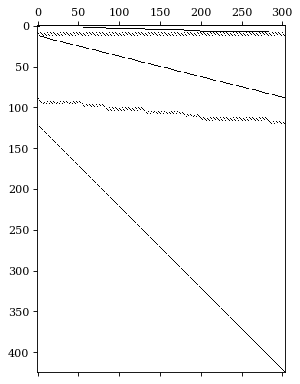

In [19]:
#| hide
hplots = HierarchicalPlot(S=S_df, tags=tags)
hplots.plot_summing_matrix()

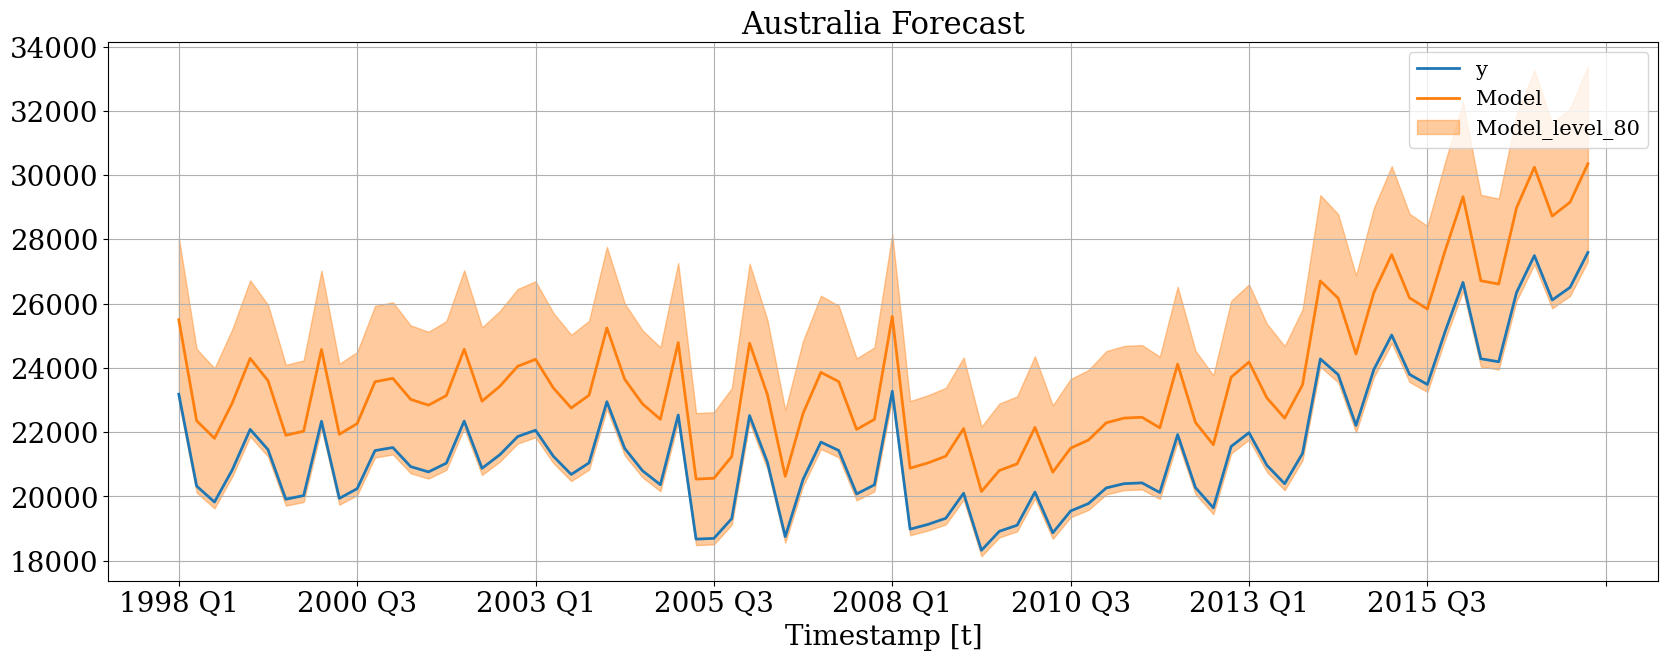

In [20]:
#| hide
hier_df['Model'] = hier_df['y'] * 1.1
hier_df['Model-lo-80'] = hier_df['Model'] - 0.1 * hier_df['Model']
hier_df['Model-hi-80'] = hier_df['Model'] + 0.1 * hier_df['Model']
hplots.plot_series(
    series='Australia', 
    Y_df=hier_df,
    level=[80, 90]
)

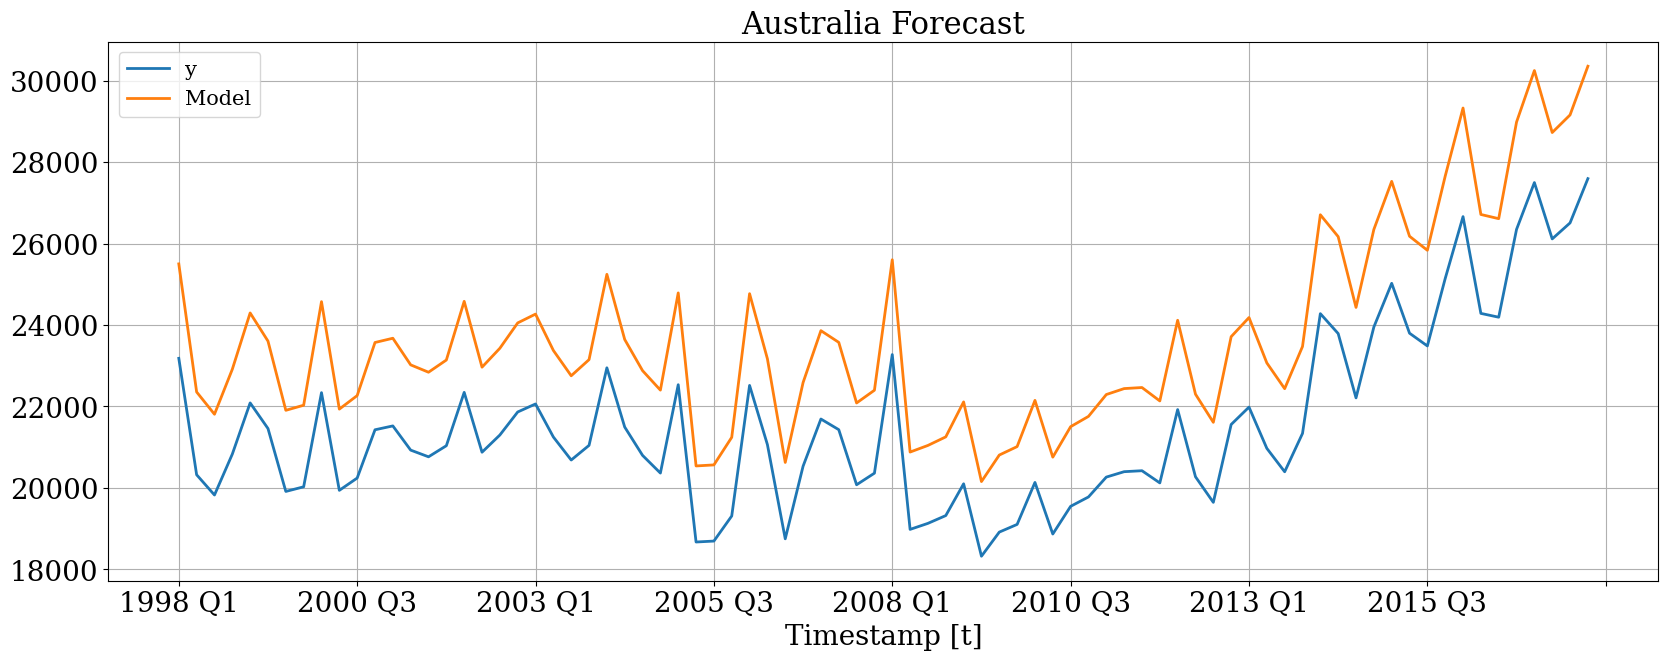

In [21]:
#| hide
hplots.plot_series(series='Australia', 
                   Y_df=hier_df)

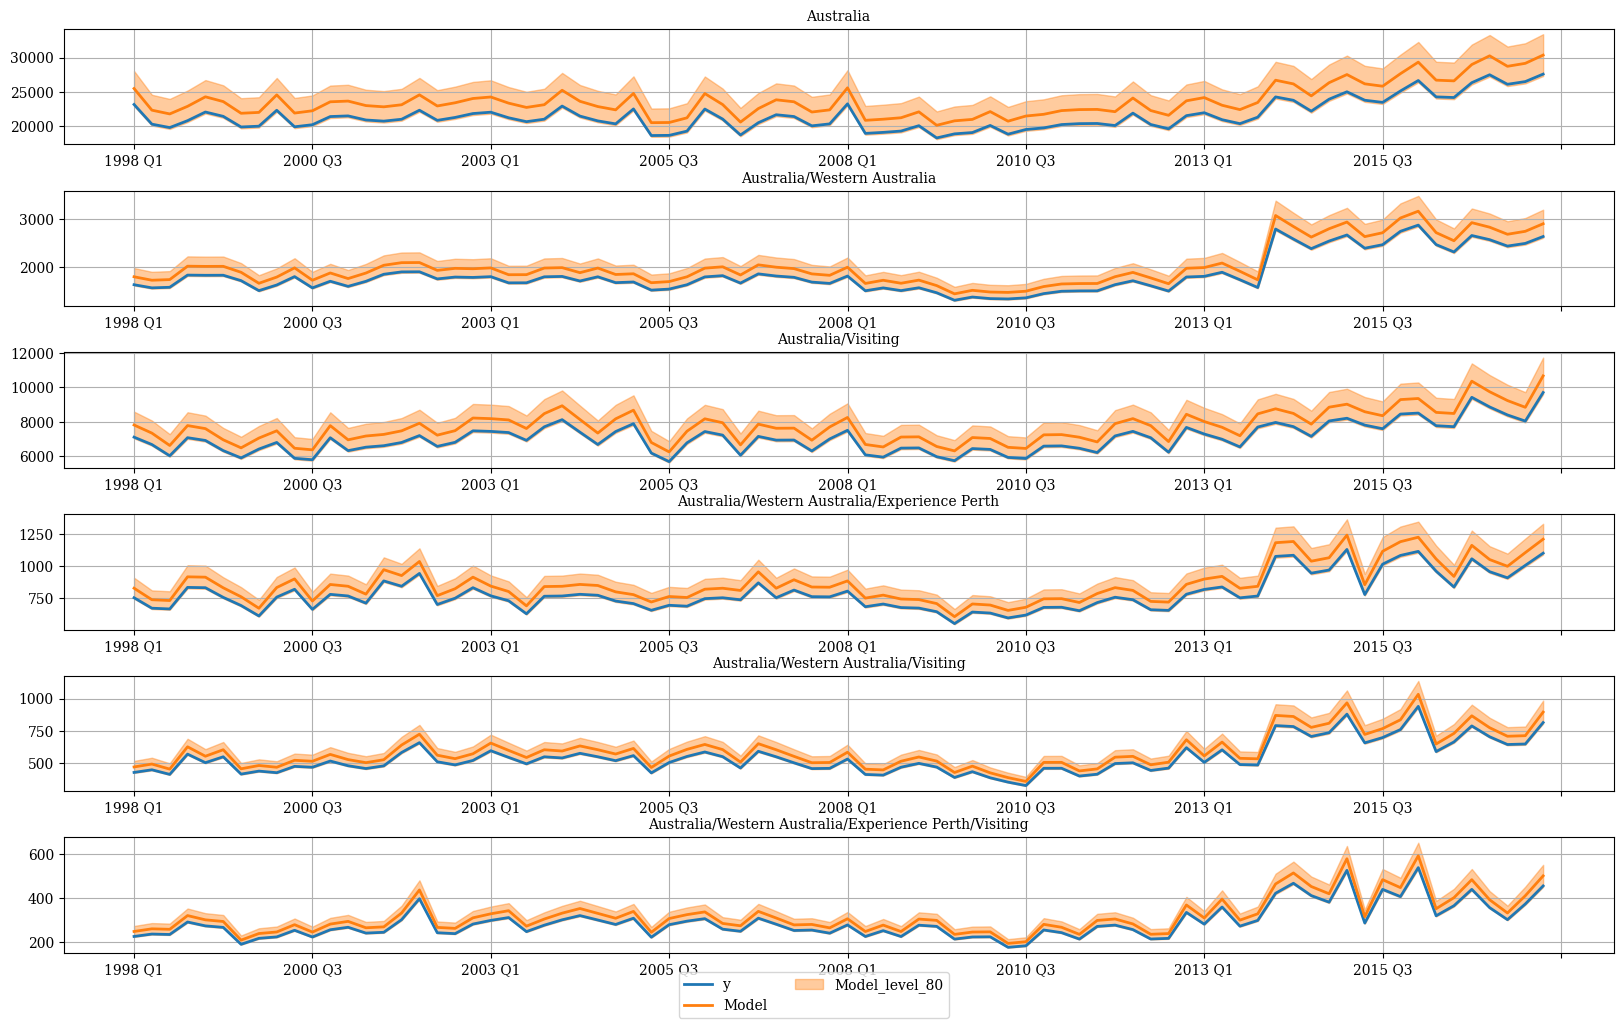

In [22]:
#| hide
hplots.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting', 
    Y_df=hier_df,
    level=[80, 90]
)

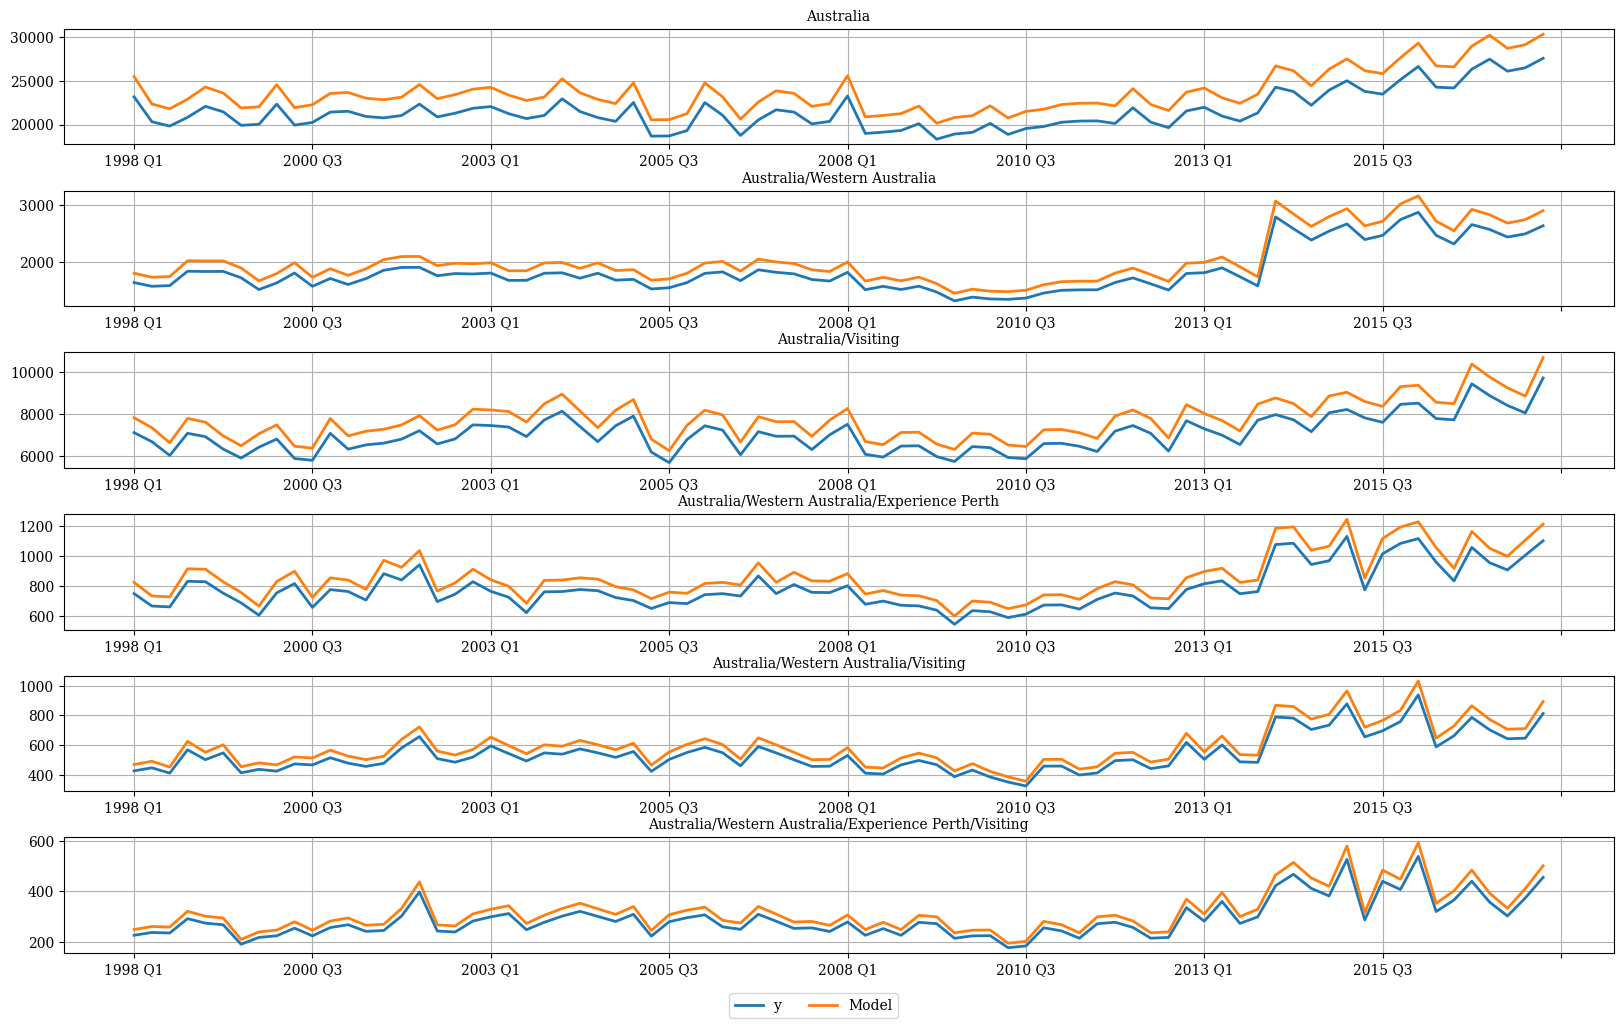

In [23]:
#| hide
hplots.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting', 
    Y_df=hier_df,
)

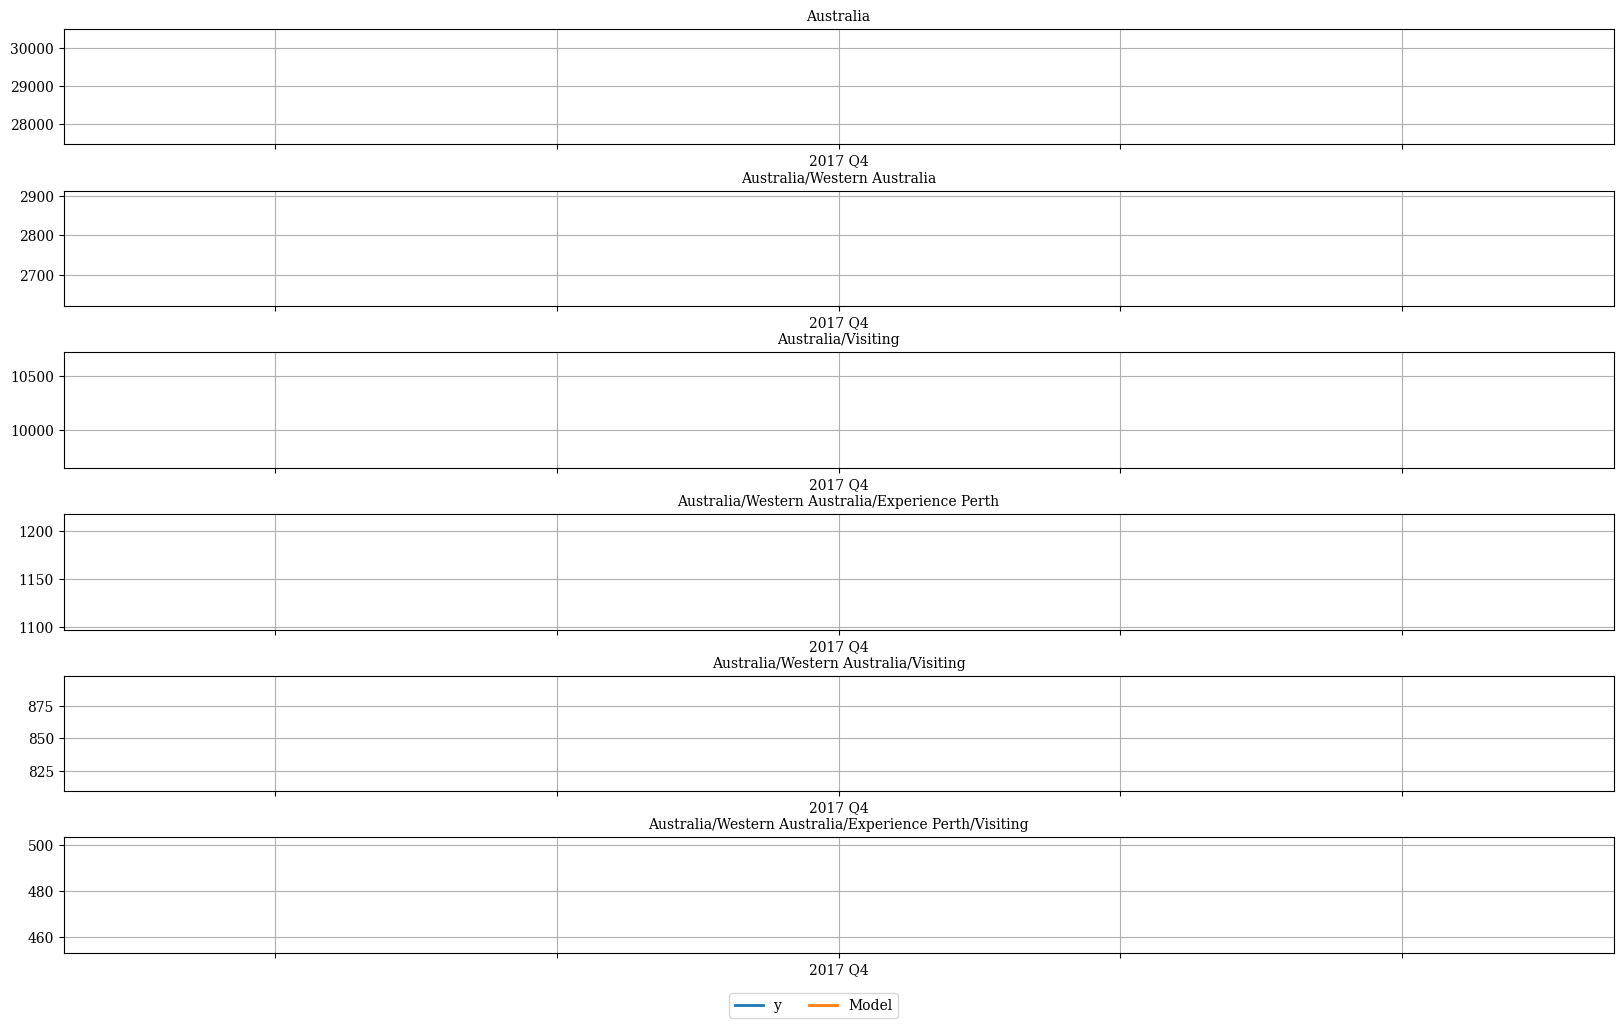

In [24]:
#| hide
# test series with just one value
hplots.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting', 
    Y_df=hier_df.groupby('unique_id').tail(1),
)

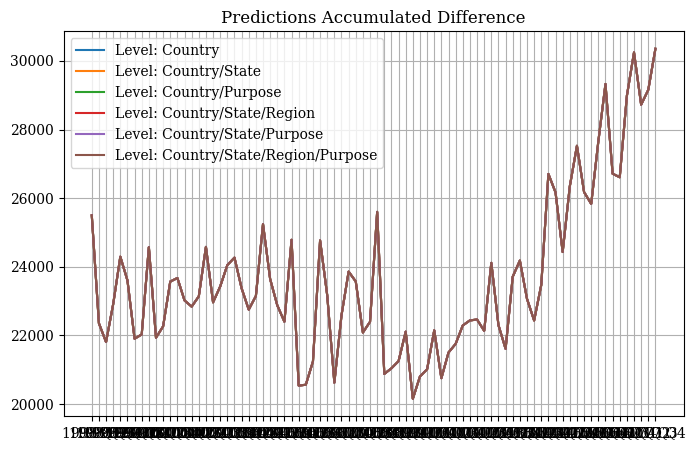

In [25]:
#| hide
hplots.plot_hierarchical_predictions_gap(Y_df=hier_df.drop(columns='y'), models=['Model'])

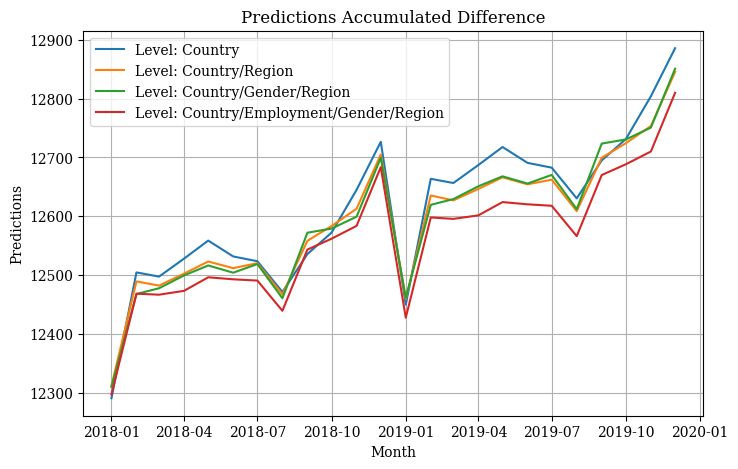

In [26]:
#| eval: false
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, ETS, Naive
from datasetsforecast.hierarchical import HierarchicalData

Y_df, S_df, tags = HierarchicalData.load('./data', 'Labour')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_test_df  = Y_df.groupby('unique_id').tail(24)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df  = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

fcst = StatsForecast(
    df=Y_train_df, 
    #models=[AutoARIMA(season_length=12), Naive()], 
    models=[ETS(season_length=12, model='AAZ')],
    freq='MS', 
    n_jobs=-1
)
Y_hat_df = fcst.forecast(h=24)

# Plot prediction difference of different aggregation
# Levels Country, Country/Region, Country/Gender/Region ...
hplots = HierarchicalPlot(S=S_df, tags=tags)

hplots.plot_hierarchical_predictions_gap(
    Y_df=Y_hat_df, models='ETS',
    xlabel='Month', ylabel='Predictions',
)